In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim

In [70]:
patients_df = pd.read_csv('data/adhd_data.csv')
# patients_df[::] # Commented out to avoid printing sensitive data

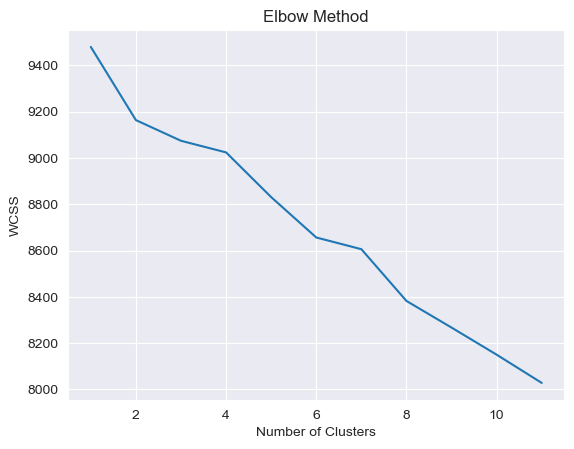

In [3]:
# Use PCA to reduce the dimensionality of the data and then plot the clusters

# Preprocess data to numbers
data_encoded = pd.get_dummies(patients_df, ["drug"])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_encoded)

def get_optimal_clusters(data, min_clusters=1, max_clusters=10):
    wcss = []
    for i in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=30, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(min_clusters, max_clusters), wcss)
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.show()

# Split into clusters that have at least 10 items in them
get_optimal_clusters(df_scaled, 1, len(data_encoded) // 10)


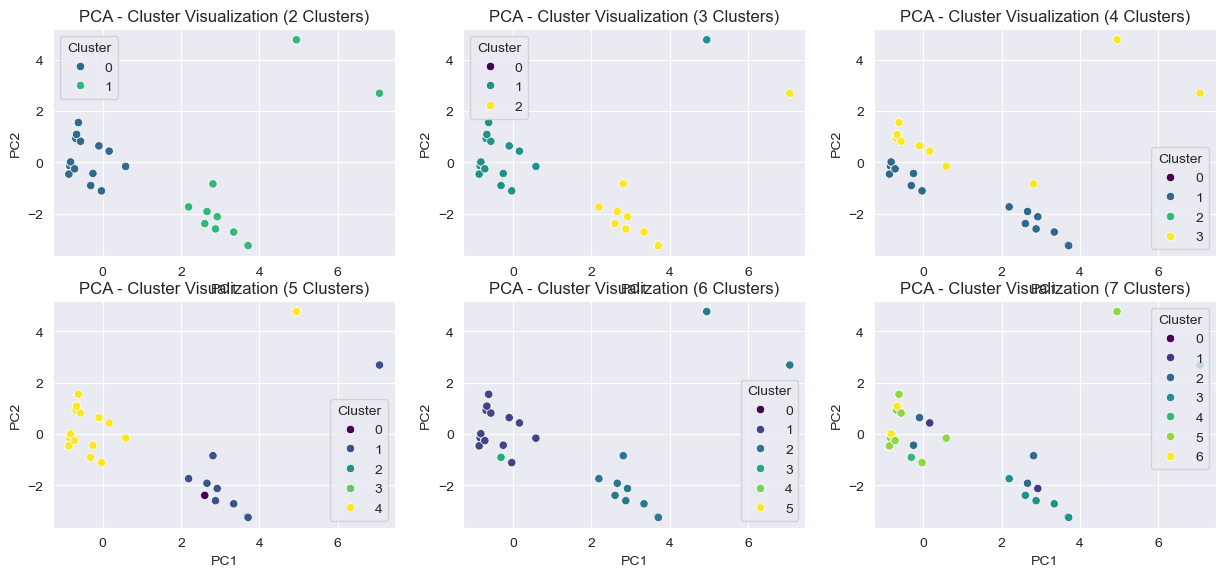

In [4]:
def run_kmeans(k, data):
    kmeans = KMeans(n_clusters=k, random_state=30, n_init=10)
    clusters = kmeans.fit_predict(data)

    df_pca = pca.fit_transform(data)

    # Convert to DataFrame
    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = kmeans.labels_
    return (df_pca, clusters, k)

# Reduce to 2 principal components
pca = PCA(n_components=2)

# Run kmeans for 2-5 clusters
ks = [run_kmeans(i, df_scaled) for i in range(2,8)]

# Scatter plot of clusters
plt.figure(figsize=(15,10))

for i in range(len(ks)):
    k = ks[i]
    plt.subplot(3,3,i+1)
    sns.scatterplot(data=k[0], x="PC1", y="PC2", hue="Cluster", palette="viridis")
    plt.title(f"PCA - Cluster Visualization ({k[2]} Clusters)")
plt.show()

In [5]:
# Selecting best performing cluster model (2 cluster model)
data_encoded['cluster'] = ks[0][1]

# Decode the encoded features
feature_columns = data_encoded.drop(columns="cluster").columns

pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
pc1_values = pca_components.T.sort_values(by="PC1", ascending=False).head(10)
pc2_values = pca_components.T.sort_values(by="PC2", ascending=False).head(10)

# Show features that contribute most to PC1 and PC2
# print(f"Top Features in PC1: {pc1_values} \n\nTop Features in PC2:{pc2_values}")
print(f"Top Features in PC1: \n{pc1_values}")

Top Features in PC1: 
                               PC1       PC2
hallucinations            0.448624 -0.368941
ocd                       0.400497  0.418098
drug_Olanzapine           0.231711  0.113439
drug_Diazepam             0.176265 -0.177837
drug_Lorazepam            0.172833 -0.194849
drug_Oxcarbazepine        0.162162  0.201403
drug_Ranitidine (Liquid)  0.162162  0.201403
drug_DiphenhydrAMINE      0.162162  0.201403
drug_Phenytoin Sodium     0.162162  0.201403
drug_Thiamine             0.121115 -0.136190


In [6]:
print(f"Top Features in PC2:\n{pc2_values}")

Top Features in PC2:
                                                      PC1       PC2
ocd                                              0.400497  0.418098
drug_DiphenhydrAMINE                             0.162162  0.201403
drug_Phenytoin Sodium                            0.162162  0.201403
drug_Ranitidine (Liquid)                         0.162162  0.201403
drug_Oxcarbazepine                               0.162162  0.201403
adhd_only                                       -0.567956  0.133627
drug_Calcium Carbonate                          -0.035915  0.115757
drug_Olanzapine                                  0.231711  0.113439
drug_Tetanus-DiphTox-Acellular Pertuss (Adacel) -0.020362  0.065286
drug_Ritonavir (Oral Solution)                  -0.020362  0.065286


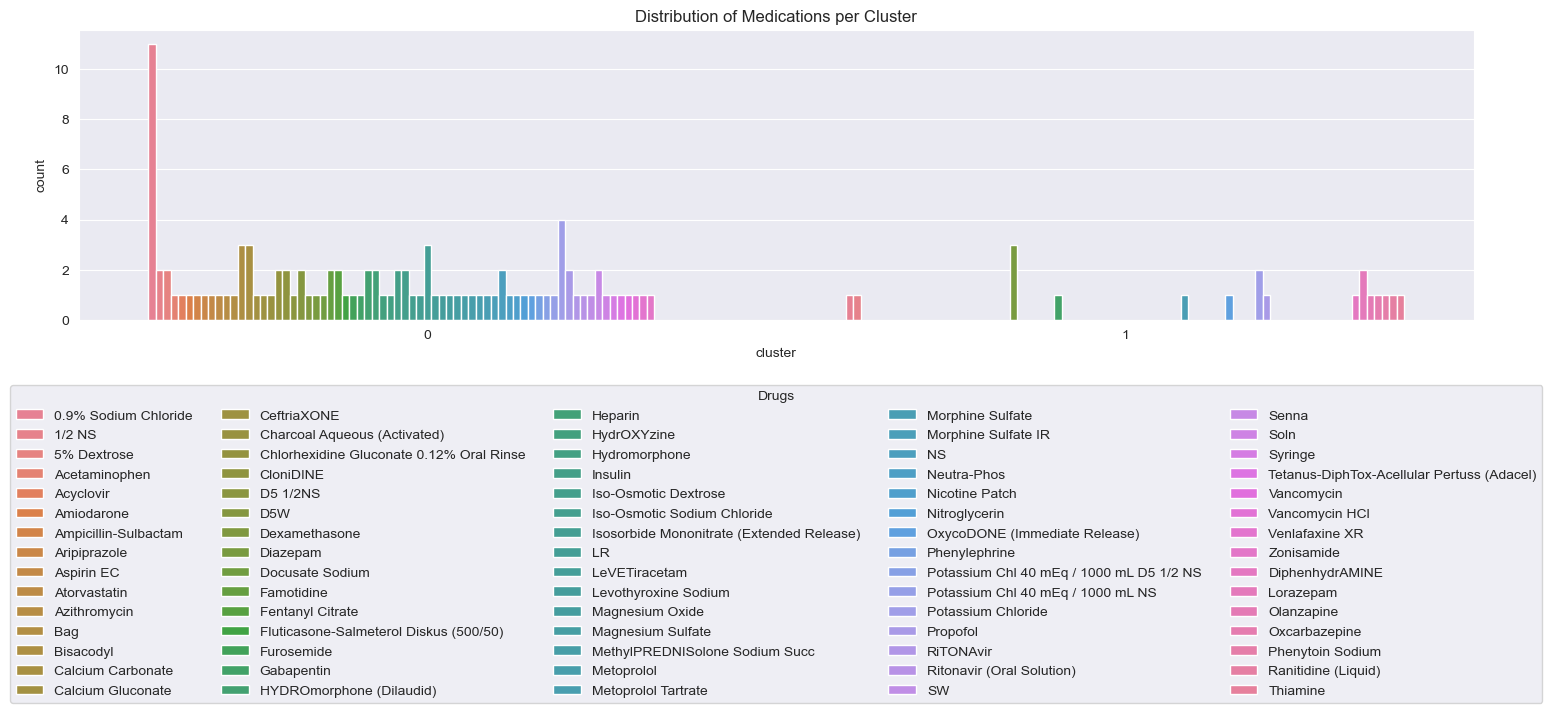

In [7]:
# decode drugs & plot them
drug_col = [col for col in data_encoded.columns if col.startswith("drug_")]
data_melted = pd.melt(data_encoded, id_vars="cluster",
                      value_vars=drug_col,
                      var_name="drug",
                      value_name="presence")
data_melted = data_melted[data_melted["presence"] == 1]
data_melted["drug"] = data_melted["drug"].str.replace("drug_", "")

plt.figure(figsize=(18,5))
sns.countplot(x="cluster", hue="drug", data=data_melted)
plt.title("Distribution of Medications per Cluster")

plt.legend(title="Drugs", bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=5)
plt.subplots_adjust(bottom=0.3)
plt.show()

In [63]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def run_model(data, encoded_data, epochs):
    # Prepare data
    df_tensor = torch.tensor(data, dtype=torch.float32)

    # Initialize and train the autoencoder
    model = Autoencoder(input_dim=df_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for i in range(epochs):
        optimizer.zero_grad()
        output = model(df_tensor)
        loss = criterion(output, df_tensor)
        loss.backward()
        optimizer.step()

    # Extract encoded features
    encoded_features = model.encoder(df_tensor).detach().numpy()

    # Cluster with K-Means
    kmeans = KMeans(n_clusters=3, random_state=30, n_init=10)
    data_encoded['cluster_model'] = kmeans.fit_predict(encoded_features)

    feature_names = encoded_data.columns  # Get the column names before scaling
    print(f"Original Features: {len(feature_names)}, Latent Space Features: {encoded_features.shape[1]}")

    # Extract the encoder weights
    encoder_weights = model.encoder[0].weight.detach().numpy()

    # Remove the 2 added features from the encoder ()
    feature_names = feature_names[:79]

    # Create a DataFrame to map feature contributions
    latent_feature_importance = pd.DataFrame(encoder_weights, columns=feature_names)
    latent_dim = encoded_features.shape[1]

    # Identify the most contributing features for each latent dimension
    top_features = [latent_feature_importance.iloc[i].idxmax() for i in range(latent_dim)]

    return top_features, encoded_features, kmeans

def plot_latent_space_2d(top_features, encoded_feats, kmeans):
    # Update the plot labels
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=encoded_feats[:, 0], y=encoded_feats[:, 1],
                    hue=kmeans.labels_, palette="viridis", s=100, alpha=0.7)
    plt.title("Latent Space Representation from Autoencoder")
    plt.xlabel(f"Encoded Feature 1 ({top_features[0]})")
    plt.ylabel(f"Encoded Feature 2 ({top_features[1]})")
    plt.legend(title="Cluster")
    plt.show()

def plot_latent_space_3d(top_features, encoded_features, kmeans):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(encoded_features[:, 0], encoded_features[:, 1], encoded_features[:, 2], c=kmeans.labels_, cmap="viridis")
    ax.set_xlabel(f"Encoded Feature 1 ({top_features[0]})")
    ax.set_ylabel(f"Encoded Feature 2 ({top_features[1]})")
    ax.set_zlabel(f"Encoded Feature 3 ({top_features[2]})")

    plt.title("3D Latent Space Representation")
    plt.show()

Original Features: 81, Latent Space Features: 8


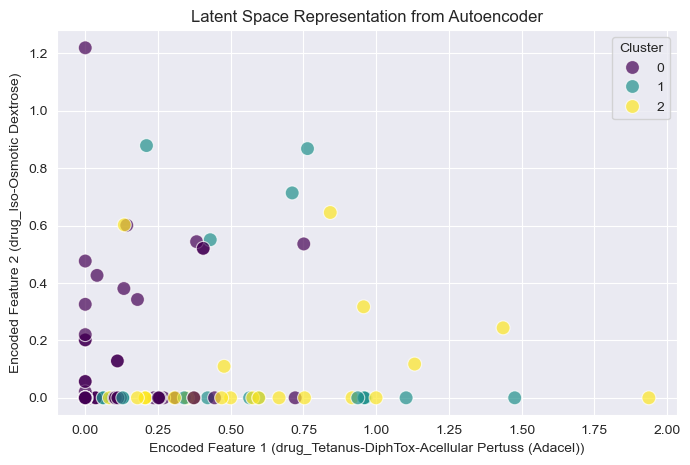

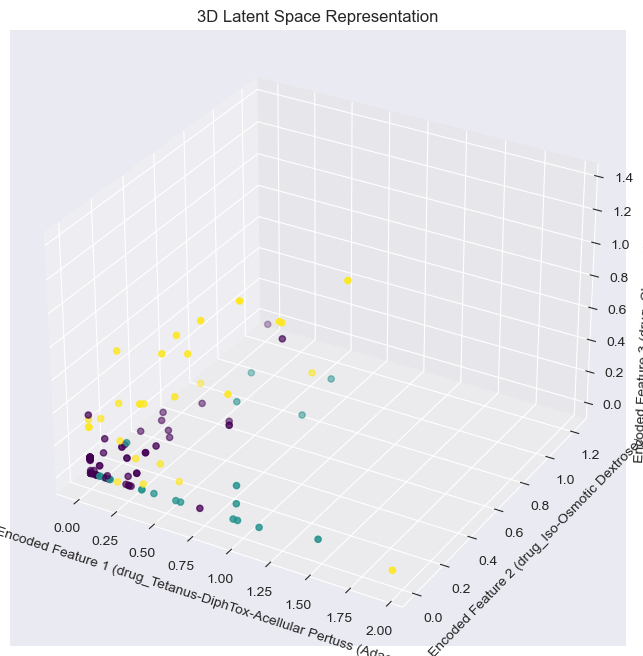

In [69]:
top_feats, enc_feats, km = run_model(df_scaled, data_encoded, 10)
plot_latent_space_2d(top_feats, enc_feats, km)
plot_latent_space_3d(top_feats, enc_feats, km)

In [59]:
print(top_feats)

['drug_Oxcarbazepine', 'drug_Venlafaxine XR', 'drug_Vancomycin HCl', 'drug_D5W', 'drug_Potassium Chl 40 mEq / 1000 mL NS', 'drug_Venlafaxine XR', 'drug_Metoprolol', 'drug_Vancomycin HCl']
